### 1 Pre Requieries 

#### 1.1 importing and setting 

In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
from networkx import path_graph,incidence_matrix
from qpsolvers import solve_qp
import scipy
from time import time
from pyswarm import pso
from numba import jit
import seaborn as sns
from datetime import datetime
n = 7
delta_t = 0.02
duration = 3

#### 1.2 Plotting function 

In [2]:
def plot_vehicle_control_analysis(velocities, relative_d, U,steps,delta_t,lb:float,ub:float):
    """
    Plot vehicle control system analysis with three subplots.
    
    Parameters:
    -----------
    velocities : numpy.ndarray
        Vehicle velocities data
    relative_d : numpy.ndarray
        Relative distances data
    U : numpy.ndarray
        Control effort data
    n : int
        Number of vehicles/colors for the plot
    """
    # Calculate time points
    time_points = np.arange(0, steps * delta_t, delta_t)
    seconds = np.arange(0, duration + 1)
    second_indices = [int(s/delta_t) for s in seconds]
    # Remove grid lines from all axes
    plt.rcParams['axes.grid'] = False
    # Create figure with shared x axis
    fig = plt.figure(figsize=(6, 12))
    gs = fig.add_gridspec(3, 1, hspace=0.3)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax3 = fig.add_subplot(gs[2], sharex=ax1)

    # Plot vehicle velocities
    ax1.plot(time_points, velocities.T)
    ax1.set_ylabel('Vehicle Velocity')
    ax1.set_title('Vehicle Velocities over Time')
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Plot relative distances
    ax2.plot(time_points, relative_d.T)
    ax2.axhline(y=lb, color='red', linestyle='--', label='Lower Safety Boundary')
    ax2.axhline(y=ub, color='blue', linestyle='--', label='Upper Safety Boundary')
    ax2.legend()
    ax2.set_ylabel('Relative Distances')
    ax2.set_title('Relative Distance over Time')
    ax2.grid(True, linestyle='--', alpha=0.7)

    # Plot control effort
    ax3.plot(time_points, U.T)
    ax3.set_xlabel('Time (seconds)')
    ax3.set_ylabel('Control Effort')
    ax3.set_title('Control Effort over Time')
    ax3.grid(True, linestyle='--', alpha=0.7)

    # Set x-axis ticks at every second
    plt.xticks(seconds)


    # Adjust layout
    plt.tight_layout()
    plt.show()

### 2 VP with PI

#### 2.1 Actual code

In [8]:
class VP():
    def __init__(self,size:int,incidenceMatrix:np.ndarray,proportional_term:float,
                 intergration_term:float
                 ,delta_t = 0.01,dtype = 'float32',solver = 'osqp',steps= 1):
        self.steps = steps 
        self.x = 6*(np.random.random((size,1)).astype(dtype)-0.5) + 7
        self.E = incidenceMatrix
        self._kappa = 2* (np.random.random((size,1)) - 0.5) + 2
        self._rho = 1*(np.random.random((size,1)).astype(dtype)-0.5) + 3
        self._lambda =2*(np.random.random((size,1)).astype(dtype)-0.5) + 7
        self.x_bar = 7*np.ones(shape=self.x.shape)
        self._zeta = np.matmul(self.E.T,self.x)
        self._eta =  np.zeros(self._zeta.shape,dtype = dtype) + 2#(np.random.random(size = self._zeta.shape).astype(dtype)-0.5)+2# np.zeros(self._zeta.shape,dtype = dtype) + 2
        self._mu = np.tanh(self._eta)
        self.delta_t =delta_t
        self.s = np.zeros((size,1),dtype=dtype)
        self.p = proportional_term
        self.i = intergration_term
        self.u = np.matmul(-self.E,self._mu) + self.p*(self.x_bar - self.x)
        +self.i*self.s


    def update(self): 
        relative_d = np.zeros((self._eta.shape[0], self.steps))
        velocities = np.zeros((self.x.shape[0], self.steps))
        U = np.zeros((self.u.shape[0], self.steps))
        for step in range(self.steps):
            U[:, step] = self.u[:, 0]
            velocities[:, step] = self.x[:, 0]
            relative_d[:, step] = self._eta[:, 0]
            self._zeta = np.matmul(self.E.T,self.x)
            self._eta += self.delta_t*self._zeta
            self._mu = np.tanh(self._eta)
            self.s += self.delta_t*(self.x_bar - self.x)
            self.u = np.matmul(-self.E,self._mu) + self.p*(self.x_bar - self.x) +self.i*self.s

            self.f_x = self._kappa*(-(self.x - self._lambda) +(1/self._rho)*self.u )
            self.x += self.delta_t*self.f_x
        return U, relative_d, velocities


#### 2.2 Simulation


C:\Users\hozna\AppData\Local\Temp\ipykernel_10860\2788417045.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


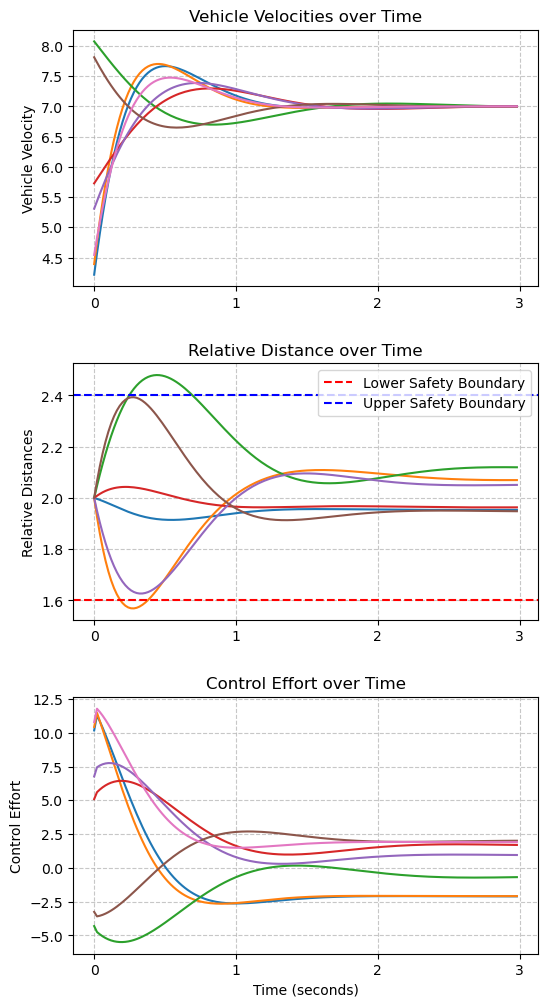

In [9]:



steps = int(duration*(1/delta_t))
Imatrix = -scipy.sparse.csr_matrix.toarray(incidence_matrix(path_graph(n=n), oriented=True))
graph = VP(size = n,incidenceMatrix=Imatrix,proportional_term=4,intergration_term=20,delta_t=delta_t,
            solver='daqp',steps = steps)
#### saving initial states for later use 
X = np.copy(graph.x)
X_bar = np.copy(graph.x_bar)
Eta = np.copy(graph._eta)
Lambda = np.copy(graph._lambda)
Kappa = np.copy(graph._kappa)
Rho = np.copy(graph._rho)
Gamma = Kappa/Rho
U, relative_d, velocities = graph.update()
plot_vehicle_control_analysis(velocities, relative_d, U, delta_t=delta_t,steps=steps,lb=1.6,ub=2.4)


### 3 VP , Nominal safety 

#### 3.1 Actual code 

In [10]:
class VP():
    def __init__(self,size:int,incidenceMatrix:np.ndarray,proportional_term:float,
                 intergration_term:float
                 ,delta_t = 0.01,dtype = 'float32',solver = 'osqp',steps= 1):
        self.steps = steps
        self.dim = size
        self.x = 2*np.random.random((size,1)).astype(dtype) + 5
        self.E = incidenceMatrix
        self._kappa =1*np.ones((size,1),dtype=dtype)
        self._rho = np.random.random((size,1)).astype(dtype) + 1
        self._lambda  = np.random.random((size,1)).astype(dtype) + 5
        self.x_bar = 5.5*np.ones((size,1),dtype=dtype)
        self._zeta = np.matmul(self.E.T,self.x)
        self._eta = np.zeros(self._zeta.shape,dtype = dtype) + 2
        self._mu = np.tanh(self._eta)
        self.delta_t =delta_t
        self.s = np.zeros((size,1),dtype=dtype)
        self.p = proportional_term
        self.i = intergration_term
        self.u = np.zeros(shape=self.x.shape)#np.matmul(-self.E,self._mu) + self.p*(self.x_bar - self.x) +self.i*self.s
        self.gamma = self._kappa/self._rho
        self.k1,self.k2 = (20,20)
        self.solver = solver 
        self.loc = np.arange(0,size*2,2).reshape(-1,1).astype(dtype)
    def update(self,lb,ub,safe=True,mode ='ublb'): 
        assert lb<ub
        self.eta_min = lb
        self.eta_max = ub
        self._eta_p = (self.eta_min+self.eta_max)/2
        self._eta_q = (self.eta_max- self.eta_min)/2
        relative_d = np.zeros((self._eta.shape[0], self.steps))
        velocities = np.zeros((self.x.shape[0], self.steps))
        self.L = np.zeros((self.x.shape[0], self.steps))
        U = np.zeros((self.u.shape[0], self.steps))

        for step in range(self.steps):
            U[:, step] = self.u[:, 0]
            velocities[:, step] = self.x[:, 0]
            relative_d[:, step] = self._eta[:, 0]
            self.L[:,step] = self.loc[:,0]
            self._zeta = np.matmul(self.E.T,self.x)
            self._eta += self.delta_t*self._zeta
            self.eta_bar = self._eta - self._eta_p
            self._mu = np.tanh(self._eta)
            self.s += self.delta_t*(self.x_bar - self.x)
            self.u = np.matmul(-self.E,self._mu) + self.p*(self.x_bar - self.x) +self.i*self.s
            if safe: 
                P = 2*(2*np.eye(N = self.dim))
                P[0,0],P[-1,-1] = (2.0,2.0)
                q = -2*(2*self.u.T)
                q[0,0],q[0,-1] = (0.5*q[0,0],0.5*q[0,-1])
                if mode == 'ublb':
                    g = 2*np.diag(self.eta_bar[:,0])@(self.E.T)@np.diag(self.gamma[:,0]) #-2*(self._eta*1*self.E*self.gamma).T
                    P = scipy.sparse.csc_matrix(P)
                    g = scipy.sparse.csc_matrix(g)
                    b_0 = -self.eta_bar**2 + self._eta_q**2
                    b_1 = -2*self.eta_bar*(self.E.T@self.x) + self.k1*b_0
                    b_2 = -2*((self.E.T@self.x)**2) + self.k1*(-2*self.eta_bar*(self.E.T@self.x)) + self.k2*(b_1)
                    h = b_2
                elif mode=='lb':
                    b_0 = self._eta - self.eta_min
                    b_1 = self.E.T@self.x + self.k1*b_0
                    b_2 = self.E.T@(self._kappa*-(self.x-self._lambda)) + self.k1*(self.E.T@self.x) + self.k2*b_1
                    g = -(self.E.T)@np.diag(self.gamma[:,0]) 
                    P = scipy.sparse.csc_matrix(P)
                    g = scipy.sparse.csc_matrix(g)
                    h = b_2




                # b_0 = -(self._eta - self.eta_min)*(self._eta - self.eta_max)
                # b_1 = -(2*self._eta - (self.eta_min+self.eta_max))*(self.E.T@self.x) + self.k1*b_0
                # b_2 = -2*((self.E.T@self.x)**2) + self.k1*(-(2*self._eta - (self.eta_min+self.eta_max))*(self.E.T@self.x)) + self.k2*b_1 + (self.E.T@(self._kappa*(self.x-self._lambda)))*-(2*self._eta -(self.eta_min+self.eta_max))
                # h = b_2
                # g = -np.diag(-2*self._eta[:,0]+(self.eta_min+self.eta_max))@(self.E.T)@np.diag(self.gamma[:,0])
                # P = scipy.sparse.csc_matrix(P)
                # g = scipy.sparse.csc_matrix(g)


                # alpha_1 = self.k1*(-((self._eta - self._eta_p)**2) + self._eta_q**2) 
                # alpha_2 = self.k2*(-2*(self._eta - self._eta_p)*(self.E.T@self.x) + alpha_1)
                
 
                # alpha_1_prim = self.k1*np.ones(shape=self._eta.shape)
                # v = -2*(self.E.T@self.x)**2 + -2*(self._eta - self._eta_p)*(self.E.T@self.x)*alpha_1_prim + alpha_2
                # h = v + -2*(self._eta - self._eta_p)*((-1*self.E.T)@(self._kappa*(self.x - self._lambda)))
                # h = -h 
                self.u = solve_qp(P,q,g,h,solver='osqp').reshape((-1,1))
            # Runge-Kutta 4th order method
            # Define the system dynamics function
            def system_dynamics(x):
                return self._kappa*(-(x - self._lambda) + (1/self._rho)*self.u)
            
            # Calculate k1, k2, k3, k4
            k1 = system_dynamics(self.x)
            k2 = system_dynamics(self.x + self.delta_t * k1/2)
            k3 = system_dynamics(self.x + self.delta_t * k2/2)
            k4 = system_dynamics(self.x + self.delta_t * k3)
            
            # Update f_x using RK4
            self.f_x = (k1 + 2*k2 + 2*k3 + k4) / 6
            self.x += self.delta_t*self.f_x
            self.loc +=self.delta_t*(self.x - self.x_bar)
        return U, relative_d, velocities





#### 3.2 Simulation 

C:\Users\hozna\AppData\Local\Temp\ipykernel_10860\2788417045.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


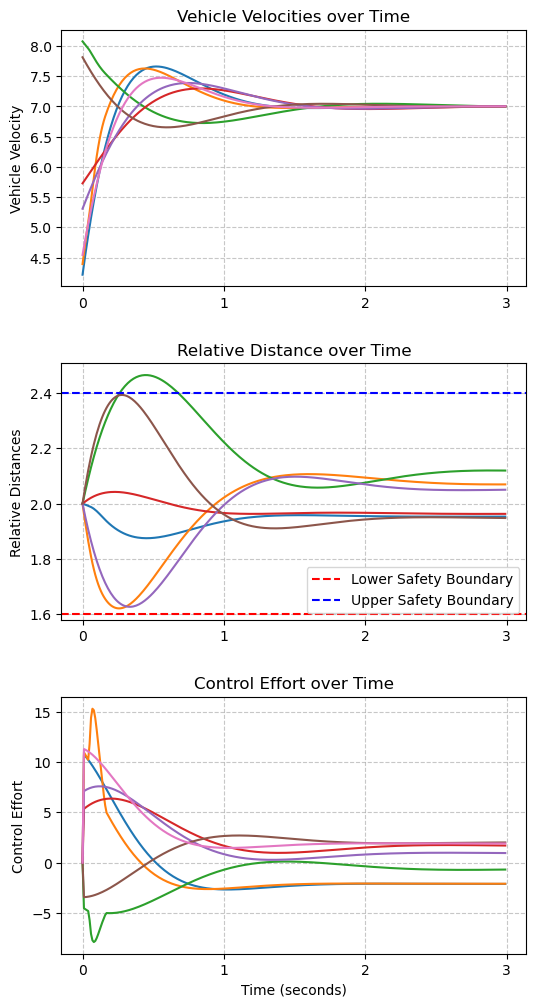

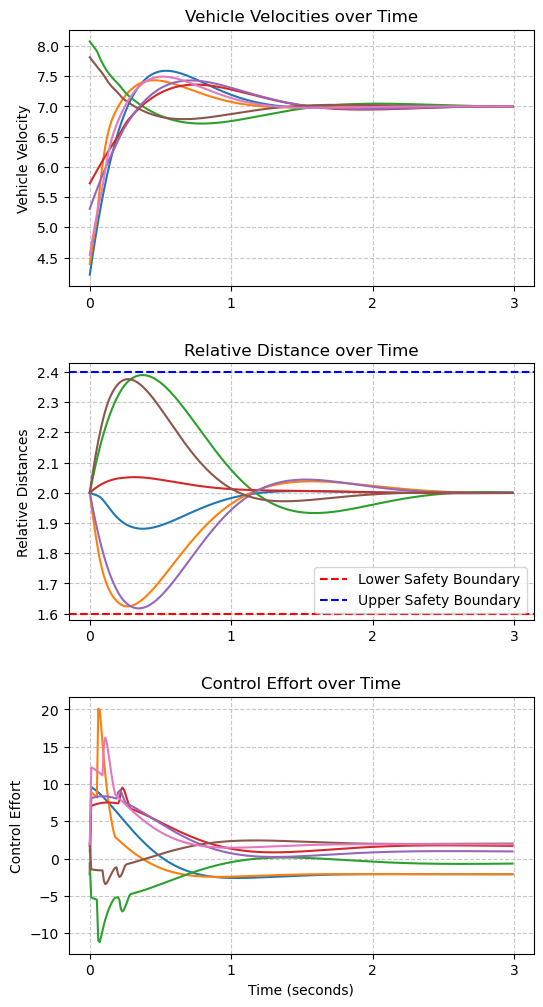

In [11]:
delta_t = 0.01
steps = int(duration*(1/delta_t))
Imatrix = -scipy.sparse.csr_matrix.toarray(incidence_matrix(path_graph(n=n), oriented=True))
graph = VP(size = n,incidenceMatrix=Imatrix,proportional_term=4,intergration_term=20,delta_t=delta_t,
            solver='daqp',steps = steps)
### set initial condition with shared values across methods 
graph.x = np.copy(X)
graph.x_bar = np.copy(X_bar)
graph._eta = np.copy(Eta) 
graph._lambda = np.copy(Lambda)
graph._kappa = np.copy(Kappa)
graph._rho = np.copy(Rho) 
graph.gamma = np.copy(Gamma)
lb= 1.6
ub = 2.4
U, relative_d, velocities = graph.update(lb = lb,ub=ub,mode='lb')
plot_vehicle_control_analysis(velocities, relative_d, U, delta_t=delta_t,steps=steps,lb = lb, ub=ub)
graph.x = np.copy(X)
graph._eta = np.copy(Eta) 
graph._lambda = np.copy(Lambda)
graph._kappa = np.copy(Kappa)
graph._rho = np.copy(Rho) 
graph.gamma = np.copy(Gamma)
U, relative_d, velocities = graph.update(lb = lb,ub=ub,mode='ublb')
plot_vehicle_control_analysis(velocities, relative_d, U, delta_t=delta_t,steps=steps,lb = lb, ub=ub)

### 4 VP Robust Safety 

#### 4.1 Actual code

In [20]:
@jit(nopython=True)
def _compute_system_update(x, u, kappa, lambda_val, rho, delta_t):
    return x + delta_t * (kappa * (-(x - lambda_val) + (1/rho)*u))


class VP():
    def __init__(self,size:int,incidenceMatrix:np.ndarray,proportional_term:float,
                 intergration_term:float,lb:float,ub:float
                 ,delta_t = 0.01,dtype = 'float32',solver = 'osqp',steps= 1):
        available_solvers = {
                                "clarabel": {"algorithm": "Interior point", "API": "Sparse", "license": "Apache-2.0"},
                                "cvxopt": {"algorithm": "Interior point", "API": "Dense", "license": "GPL-3.0"},
                                "daqp": {"algorithm": "Active set", "API": "Dense", "license": "MIT"},
                                "ecos": {"algorithm": "Interior point", "API": "Sparse", "license": "GPL-3.0"},
                                "gurobi": {"algorithm": "Interior point", "API": "Sparse", "license": "Commercial"},
                                "highs": {"algorithm": "Active set", "API": "Sparse", "license": "MIT"},
                                "hpipm": {"algorithm": "Interior point", "API": "Dense", "license": "BSD-2-Clause"},
                                "jaxopt_osqp": {"algorithm": "Augmented Lagrangian", "API": "Dense", "license": "Apache-2.0"},
                                "kvxopt": {"algorithm": "Interior point", "API": "Dense & Sparse", "license": "GPL-3.0"},
                                "mosek": {"algorithm": "Interior point", "API": "Sparse", "license": "Commercial"},
                                "nppro": {"algorithm": "Active set", "API": "Dense", "license": "Commercial"},
                                "osqp": {"algorithm": "Augmented Lagrangian", "API": "Sparse", "license": "Apache-2.0"},
                                "piqp": {"algorithm": "Proximal interior point", "API": "Dense & Sparse", "license": "BSD-2-Clause"},
                                "proxqp": {"algorithm": "Augmented Lagrangian", "API": "Dense & Sparse", "license": "BSD-2-Clause"},
                                "qpalm": {"algorithm": "Augmented Lagrangian", "API": "Sparse", "license": "LGPL-3.0"},
                                "qpax": {"algorithm": "Interior point", "API": "Dense", "license": "MIT"},
                                "qpoases": {"algorithm": "Active set", "API": "Dense", "license": "LGPL-2.1"},
                                "qpswift": {"algorithm": "Interior point", "API": "Sparse", "license": "GPL-3.0"},
                                "quadprog": {"algorithm": "Active set", "API": "Dense", "license": "GPL-2.0"},
                                "scs": {"algorithm": "Augmented Lagrangian", "API": "Sparse", "license": "MIT"},
                                "sip": {"algorithm": "Barrier Augmented Lagrangian", "API": "Sparse", "license": "MIT"},
                            }
        self.steps = steps
        self.dim = size
        self.x = 2*np.random.random((size,1)).astype(dtype) + 5 
        self.E = incidenceMatrix
        self._kappa = (np.ones((size,1),dtype=dtype)-0.1) +0.2 * np.random.random((size,1)) 
        self._rho = np.random.random((size,1)).astype(dtype) + 1
        self._lambda  = np.random.random((size,1)).astype(dtype) + 5
        self.x_bar = 5.5*np.ones((size,1),dtype=dtype)
        self._zeta = np.matmul(self.E.T,self.x)
        self._eta = np.zeros(self._zeta.shape,dtype = dtype) + 2
        self._eta_0 = np.copy(self._eta)
        self._mu = self._eta 
        self.delta_t =delta_t
        self.s = np.zeros((size,1),dtype=dtype)
        self.K_p = proportional_term*np.ones(shape=(self.dim))
        self.K_i = intergration_term*np.ones(shape=(self.dim))
        self.u = (self.K_p*(self.x_bar - self.x)[:,0]).reshape((-1,1)) +(self.K_i*self.s[:,0]).reshape((-1,1))#+np.matmul(-self.E,self._mu)  
        #self.mamad =  (self.K_p*(self.x_bar - self.x)[:,0]).reshape((-1,1)) +(self.K_i*self.s[:,0]).reshape((-1,1))
        self._gamma = self._kappa/self._rho
        self.k1,self.k2 = (10,10)
        self.solver = solver 

		### estimation of parameters 
        self._kappa_hat = np.ones(shape = self._kappa.shape) * 2
        self._rho_hat = np.ones(shape = self._rho.shape) * 3
        self._lambda_hat = np.ones(shape= self._lambda.shape) * 7
        self.gamma_hat = self._kappa_hat/self._rho_hat 
        
        self.delta_kappa = 0.5*np.ones(shape=self._kappa.shape)
        self.delta_rho = 0.5*np.ones(shape=self._rho.shape) 
        self.delta_lambda = 1*np.ones(shape=self._lambda.shape)
        
        # self._rho_hat = self._rho + self.delta_rho*np.random.random((self._rho.shape))
        # self._kappa_hat = self._kappa + self.delta_kappa*np.random.random((self._kappa.shape))
        # self._lambda_hat = self._lambda +self.delta_lambda*np.random.random((self._lambda.shape))
        # self.gamma_hat = self._kappa_hat/self._rho_hat 


        gamma_hati = self.gamma_hat[0][0]
        gamma_hatj = self.gamma_hat[0][0]
        kappa_hati = self._kappa_hat[0][0]
        kappa_hatj = self._kappa_hat[0][0]
        rho_hati = self._rho_hat[0][0]
        rho_hatj = self._rho_hat[0][0]
        lambda_hati= self._lambda_hat[0][0]
        lambda_hatj= self._lambda_hat[0][0]
        self.delta11 = self.delta_kappa[0]
        self.delta12 = self.delta_kappa[0]
        self.delta21 = kappa_hati*self.delta_lambda[0] + lambda_hati*self.delta_kappa[0] + self.delta_kappa[0]*self.delta_lambda[0]
        self.delta22 = kappa_hati*self.delta_lambda[0] + lambda_hati*self.delta_kappa[0] - self.delta_kappa[0]*self.delta_lambda[0]
        self.delta31 = ((kappa_hati+self.delta_kappa[0])/(rho_hati-self.delta_rho[0]))-(kappa_hati/rho_hati)
        self.delta32 = -((kappa_hati-self.delta_kappa[0])/(rho_hati+self.delta_rho[0]))+(kappa_hati/rho_hati)
    
        self.delta41 = self.delta_kappa[0]
        self.delta42 = self.delta_kappa[0]
        self.delta51 = kappa_hatj*self.delta_lambda[0] + lambda_hatj*self.delta_kappa[0] + self.delta_kappa[0]*self.delta_lambda[0]
        self.delta52 = kappa_hatj*self.delta_lambda[0] + lambda_hatj*self.delta_kappa[0] - self.delta_kappa[0]*self.delta_lambda[0]
        self.delta61 = ((kappa_hatj+self.delta_kappa[0])/(rho_hatj-self.delta_rho[0]))-(kappa_hatj/rho_hatj)
        self.delta62 = -((kappa_hatj+self.delta_kappa[0])/(rho_hatj-self.delta_rho[0]))+(kappa_hatj/rho_hatj)




        ### safety filter optimization parameters

        self.A = np.array([[0,1,-1,0,0,0,0,0,0,0,0,0,0],
                           [0,0,0,1,-1,0,0,0,0,0,0,0,0],
                           [0,0,0,0,0,1,-1,0,0,0,0,0,0],
                           [0,0,0,0,0,0,0,1,-1,0,0,0,0],
                           [0,0,0,0,0,0,0,0,0,1,-1,0,0],
                           [0,0,0,0,0,0,0,0,0,0,0,1,-1]]).astype('float64')
        self.lb = -np.inf*np.ones((13,1))
        self.ub = np.zeros((13,1))
        self.ub[0] = +np.inf
        self.P = 4*np.eye(13)
        self.Q = np.zeros((13,1))
        self.G = np.array([[0],
                    [-kappa_hati-self.delta11[0]],
                    [kappa_hati-self.delta12[0]],
                    [-kappa_hati*lambda_hati- self.delta21[0]],
                    [kappa_hati*lambda_hati - self.delta22[0]],
                    [-kappa_hatj-self.delta41[0]],
                    [kappa_hatj-self.delta42[0]],
                    [-kappa_hatj*lambda_hatj-self.delta51[0]],
                    [kappa_hatj*lambda_hatj-self.delta52[0]],
                    [-self.delta31[0]],
                    [-self.delta32[0]],
                    [-self.delta61[0]],
                    [-self.delta62[0]]]).T
        if available_solvers[self.solver]['API']== 'Sparse':
            self.P = scipy.sparse.csc_matrix(self.P)
            self.A =  scipy.sparse.csc_matrix(self.A)
            self.G = scipy.sparse.csc_matrix(self.G)
        self.mode = 'optimization'
        # Initialize B vector
        self.B = np.zeros((6, 1))

        assert lb<ub
        self.eta_min = lb
        self.eta_max = ub
        self._eta_p = (self.eta_min+self.eta_max)/2
        self._eta_q = (self.eta_max- self.eta_min)/2

    def set_mode(self,mode:str):
        """
        modes: ['optimization','simulation']
        """
        self.mode = mode
    


    def copy_initial_values(self):
        self.x_init = np.copy(self.x)
        self.x_bar_init = np.copy(self.x_bar)
        self.s_init = np.copy(self.s)
        self._eta_init = np.copy(self._eta)
        self._mu_init = np.copy(self._mu)
        self._zeta_init = np.copy(self._zeta)
        self.u_init = np.copy(self.u)

    def reset(self):
        self.x = np.copy(self.x_init)
        self.x_bar = np.copy(self.x_bar_init)
        self.s = np.copy(self.s_init)
        self._eta = np.copy(self._eta_init)
        self._mu = np.copy(self._mu_init)
        self._zeta = np.copy(self._zeta_init)
        self.u = np.copy(self.u_init)



    def update(self,x):
        self.reset()
        self.k1 = x[-1]
        self.k2 = x[-2]
        self.K_p = x[:self.dim]
        self.K_i = x[self.dim:2*self.dim] 

        # Pre-allocate arrays
        relative_d = np.zeros((self._eta.shape[0], self.steps))
        velocities = np.zeros((self.x.shape[0], self.steps))
        U = np.zeros((self.u.shape[0], self.steps))
        
        # Pre-compute constant matrices
        ET = self.E.T
        
        for step in range(self.steps):
            # Store current state
            U[:, step] = self.u[:, 0]
            velocities[:, step] = self.x[:, 0]
            relative_d[:, step] = self._eta[:, 0]

            # Vectorized computations
            self._zeta = ET @ self.x
            self._eta += self.delta_t * self._zeta
            self.eta_bar = self._eta - self._eta_p
            self._mu = np.tanh(self._eta)
            self.s += self.delta_t * (self.x_bar - self.x)
            self.u =  (self.K_p*(self.x_bar - self.x)[:,0]).reshape((-1,1)) +(self.K_i*self.s[:,0]).reshape((-1,1))+np.matmul(-self.E,self._mu)  


            # Vectorized alpha calculations
            b_0 = -self.eta_bar**2 + self._eta_q**2
            b_1 = -2*self.eta_bar*(self.E.T@self.x) + self.k1*b_0
            b_2 = -2*((self.E.T@self.x)**2) + self.k1*(-2*self.eta_bar*(self.E.T@self.x)) + self.k2*(b_1)
            v = b_2

            # alpha_1 = self.k1 * (self._eta**2 - 1.8**2)
            # alpha_2 = self.k2 * (2*self._eta*(ET @ self.x) + alpha_1)

            # alpha_1_prim = self.k1 * np.ones_like(self._eta)
            # v = 2*(ET @ self.x)**2 + 2*self._eta*(ET @ self.x)*alpha_1_prim + alpha_2

            # Optimization loop 
            for i in range(0, self.dim-1):
                l, j = i, i+1
                xi = self.x[i, 0]
                xj = self.x[j, 0]
                eta_l = self._eta[l, 0]
                ui = self.u[i, 0]
                gamma_hati = self.gamma_hat[i, 0]
                gamma_hatj = self.gamma_hat[j, 0]
                self.A[-1, 0] = -2*(eta_l-self._eta_p)
                # Update B vector components in-place
                self.B[0, 0] = 2*(eta_l-self._eta_p)*xi
                self.B[1, 0] = -2*(eta_l-self._eta_p)
                self.B[2, 0] = -2*(eta_l-self._eta_p)*xj
                self.B[3, 0] = 2*(eta_l-self._eta_p) 
                self.B[4, 0] = -2*(eta_l-self._eta_p)*ui
                self.B[5, 0] = 0

                self.H = v[l] - 2*(eta_l-self._eta_p)*gamma_hati*ui
                self.G[0, 0] = -2*(eta_l-self._eta_p)*gamma_hatj
                self.Q[0] = -1*self.u[j]

                try:
                    O = solve_qp(P=self.P, q=self.Q, G=self.G, h=self.H, A=self.A, 
                               b=self.B, lb=self.lb, ub=self.ub, solver=self.solver)
                    self.u[j] = O[0]
                except:
                    return +np.inf

            # Use JIT-compiled function for system update
            self.x = _compute_system_update(
                self.x, self.u, self._kappa, self._lambda, self._rho, self.delta_t
            )



    

        if self.mode == 'simulation':
            return U, relative_d, velocities
        else:
            
            #velocities = self.normalize(velocities,velocities)
            #self.x_bar = self.normalize(self.x_bar,velocities)
            return self.TV(U) #+ U.__abs__().sum() + (velocities - self.x_bar).__abs__().sum() 
        #return (U,velocities,relative_d)
    def normalize(self,x,y): 
        return (x - y.min(axis = 1).reshape(-1,1))/(y.max(axis = 1).reshape(-1,1)-y.min(axis = 1).reshape(-1,1))
    def TV(self,x): 
        return np.exp((np.diff(x,n=1).__abs__() - 1)).max()


#### 4.2 simulation

C:\Users\hozna\AppData\Local\Temp\ipykernel_10860\2788417045.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


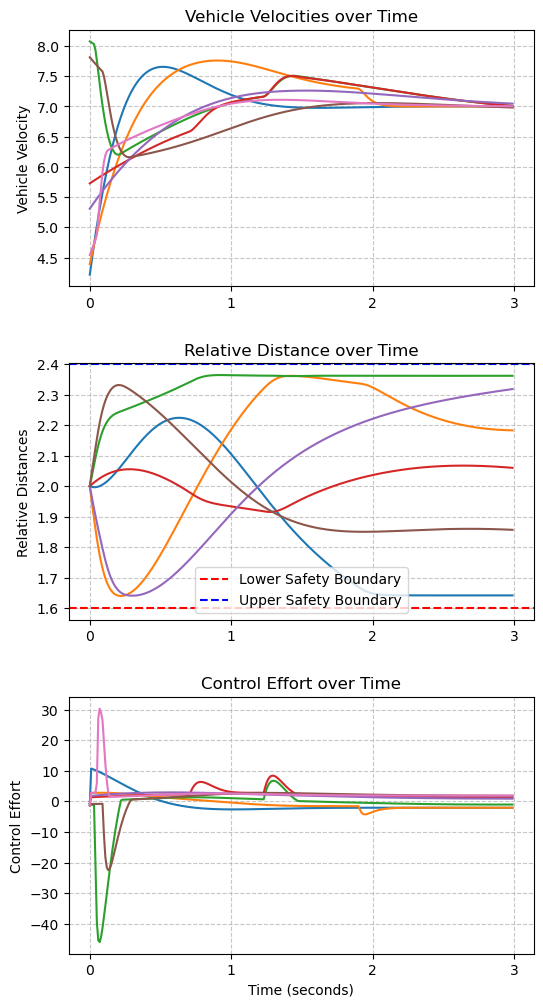

In [21]:

steps = int(duration*(1/delta_t))

lb = 1.6
ub = 2.4
Imatrix = -scipy.sparse.csr_matrix.toarray(incidence_matrix(path_graph(n=n), oriented=True))
graph = VP(size = n,incidenceMatrix=Imatrix,proportional_term=1,intergration_term=50,delta_t=delta_t,lb=lb,ub=ub,
            solver='daqp',steps = steps)



graph.set_mode('simulation')
### set initial condition with shared values across methods 
graph.x = np.copy(X)
graph.x_bar = np.copy(X_bar)
graph._eta = np.copy(Eta) 
graph._lambda = np.copy(Lambda)
graph._kappa = np.copy(Kappa)
graph._rho = np.copy(Rho) 
graph.gamma = np.copy(Gamma)
graph.copy_initial_values()
parameters = np.concatenate([4*np.ones(shape = (n)),20*np.ones(shape = (n)),[20],[20]],axis=0)
U, relative_d, velocities = graph.update(parameters)
plot_vehicle_control_analysis(velocities, relative_d, U, delta_t=delta_t,steps=steps,lb=lb,ub=ub)


### 5 VP Robust safety with tunned parameters 

#### 5.1 tunning step 

In [22]:
lb =np.ones(2*n+2)
ub = 100*np.ones(2*n+2)
graph.set_mode('optimization')
p,f = pso(graph.update, lb, ub,swarmsize=10,maxiter=10,debug=True,phig=0.4,phip=0.7,minstep=1e-11,minfunc=1e-11)

No constraints given.
New best for swarm at iteration 1: [ 4.33800696  1.         17.31018991 35.22083931 50.57298022 87.16441716
 52.87343211 74.7136042  58.53524888  8.81346767 95.62740924 71.77205703
 28.08443293 51.62232533 27.63215502 19.08363647] 256182923967333.6
Best after iteration 1: [ 4.33800696  1.         17.31018991 35.22083931 50.57298022 87.16441716
 52.87343211 74.7136042  58.53524888  8.81346767 95.62740924 71.77205703
 28.08443293 51.62232533 27.63215502 19.08363647] 256182923967333.6
Best after iteration 2: [ 4.33800696  1.         17.31018991 35.22083931 50.57298022 87.16441716
 52.87343211 74.7136042  58.53524888  8.81346767 95.62740924 71.77205703
 28.08443293 51.62232533 27.63215502 19.08363647] 256182923967333.6
Best after iteration 3: [ 4.33800696  1.         17.31018991 35.22083931 50.57298022 87.16441716
 52.87343211 74.7136042  58.53524888  8.81346767 95.62740924 71.77205703
 28.08443293 51.62232533 27.63215502 19.08363647] 256182923967333.6
New best for sw

##### tunned paramters 

In [23]:
graph.set_mode('simulation')

# U,relative_d,velocities = graph.update(  [7.05231545,  70.23290756,  55.22709498,  80.36245948,
#         100.        ,  98.48876245,  83.769239  ,  85.26504548,
#          99.98844387,  93.68812377,  92.9282099 ,  89.54666797,
#          85.91760782,  99.8423346 ,  78.63404454,  81.56115642,
#          61.12616031,  61.6306044 ,  59.96095496,  43.09050033,
#          27.03321129,  53.12250592,  16.87515839,  45.39237898,
#          84.46044144,  77.93912359,  76.9498996 ,  26.87250691,
#          72.02182974,  93.07503972,  38.10968571,  46.24984835])
# U,relative_d,velocities = graph.update( [  1.        , 236.70831735, 167.1990939 , 819.45519423,
#         680.89923054, 287.59140708, 183.43500579, 577.86781038,
#         648.99734125, 377.40954703, 553.85470464, 290.9921057 ,
#         202.3291404 , 732.63189544, 523.03695747, 530.41366067,
#         400.34187663, 506.79281023, 260.12522266, 215.07332735,
#         371.82722685, 745.82109304, 484.26837481, 681.70371615,
#         434.16634542, 255.36114879, 406.10049813, 299.79639501,
#         734.25131243, 266.38800308,  96.54325318, 266.25426924])
# U,relative_d,velocities = graph.update([  1.        , 368.45438625, 263.08691819,  18.58234512,
#         512.24597566, 111.36909983, 165.79060799,  72.80789264,
#          70.86592334, 115.86863085, 863.27305253, 646.41156802,
#         980.67501877, 504.77217656, 647.43579153, 566.6354599 ,
#         522.55247338, 635.9309673 , 620.77045208, 350.42585992,
#         989.13063332, 892.61191087])
# U,relative_d,velocities = graph.update([ 30.24025703, 406.02343858, 496.86973363, 664.30983673,
#         700.12586064, 108.94933643, 629.99904283, 228.25002886,
#         252.29317914, 220.40990159, 680.16744651, 644.18114499,
#         334.5238469 , 132.67005661, 674.809801  , 621.79452912,
#         756.03681113, 713.05582975, 340.44304506, 861.92128127,
#         704.23159965, 663.67107686])
# U,relative_d,velocities = graph.update([1.7585563, 403.82318622, 336.01427842, 636.03292587, 377.93164786,
#  686.3955782, 476.93186922, 129.49769467, 511.38834921, 108.84997639,
#  363.36123543, 628.51997648, 426.31460653, 569.37459299, 464.74427165,
#  618.42422501, 501.36230893, 713.24410112, 140.83825685, 917.91673998,
#  204.41279257, 316.43135284])

# U,relative_d,velocities = graph.update(parameters)
U,relative_d,velocities = graph.update(p)



#### 5.2 simulation 

C:\Users\hozna\AppData\Local\Temp\ipykernel_10860\2788417045.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


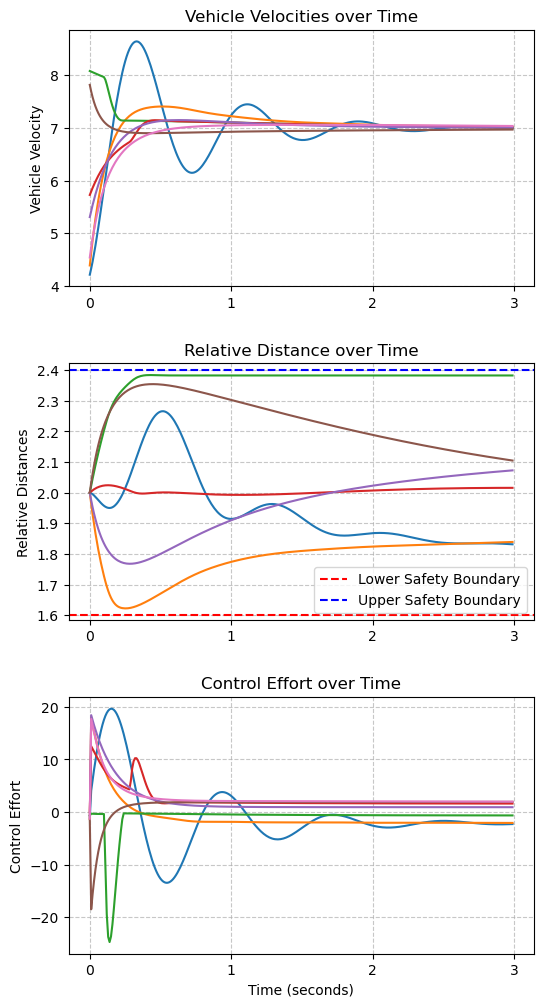

In [24]:

lb = 1.6
ub = 2.4
plot_vehicle_control_analysis(velocities, relative_d, U, delta_t=delta_t,steps=steps,lb=lb,ub=ub)